In [1]:
import numpy as np
import scipy.spatial
import tensorflow.keras.datasets as datasets
import matplotlib.pyplot as plt
import skimage as ski
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from sklearn.linear_model import LogisticRegression

np.random.seed(1337)
plt.set_cmap('gray')

## A KNN

1. Für jedes Sample für das man ein Label vorhersagen möchste muss man den Abstand zu allen Datenpunkten aus dem
Trainingsset bestimmen. Bei 50 Samples und 60.000 Trainingsdatenpunkten erhält man 50 * 60.0000 = 3.000.000 Vergleiche
2. Wenn wir jetzt die Größe des Trainingssets durch n ersetzen erhalten wir n * 50 = 50n Vergleiche.


## B KNN MNIST

Als gelabeltes Trainingsset nehmen wir 10.000 zufällige Bilder und als Testset 1.000 zufällige Bilder

### Datenset laden, splitten und formatieren

In [2]:
mnist = datasets.mnist.load_data()

train, test = mnist[0], mnist[1]

X_train, Y_train = train[0], train[1]

X_test, Y_test = test[0], test[1]

n_train = X_train.shape[0]
n_test = X_test.shape[0]

m = X_train.shape[1]**2

X_train = X_train.reshape([n_train, m])
X_test = X_test.reshape([n_test, m])

### Subsamples definieren

In [3]:
idx = np.random.randint(n_train, size=10000)
x_train_sample = X_train[idx]
y_train_sample = Y_train[idx]

In [4]:
idx = np.random.randint(n_test, size=100)
x_test_sample = X_test[idx]
y_test_sample = Y_test[idx]

### Anhand von k das label vorhersagen und kontrollieren

In [5]:
def get_error_rate(y_train, y_test, dists, k):
    total = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
    err = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
    for test_idx in range(len(dists)):
        # die k nächsten indizes suchen
        voter_indices = dists[test_idx].argsort()[:k]
        # die werte zu den inizes lesen
        voters = y_train[voter_indices]
        # den wert nehmen der am häufigsten vor kam
        predicted = max(set(voters), key=list(voters).count)
        # die werte vergleichen und fehler beziehungsweise den gesamtzähler hochsetzen
        if predicted != y_test[test_idx]:
            total[y_test[test_idx]] += 1
            err[y_test[test_idx]] += 1
        else:
            total[y_test_sample[test_idx]] += 1
    return total, err

### schöne ausgabe der ergebnisse

In [6]:
def print_knn_results(total, error):
    print("Fehlerrate: {}%".format(
        int(sum(error.values()) / sum(total.values()) * 100)))
    print("Fehlerrate nach Label (Fehler/Total):")
    for key in total.keys():
        print("{}: {}/{} -> {}%".format(key, error[key], total[key], int(error[key] / total[key] * 100)))

### die oberen beiden funktionen und die berechnung der distanzen zusammennehmen

In [7]:
def do_knn(x_train, y_train, x_test, y_test, k: int):
    dists = scipy.spatial.distance.cdist(x_test, x_train, metric='euclid')
    erg_total, erg_error = get_error_rate(y_train, y_test, dists, k)
    print_knn_results(erg_total, erg_error)

### testen der funktionen mit k=3

In [8]:
do_knn(x_train_sample, y_train_sample, x_test_sample, y_test_sample, 3)

Fehlerrate: 6%
Fehlerrate nach Label (Fehler/Total):
0: 0/10 -> 0%
1: 2/14 -> 14%
2: 2/16 -> 12%
3: 0/13 -> 0%
4: 0/3 -> 0%
5: 1/9 -> 11%
6: 0/8 -> 0%
7: 0/8 -> 0%
8: 1/14 -> 7%
9: 0/5 -> 0%


### für k = 2, 4, 8

Tendenziell verbessert sich die Fehlerrate durch ein höheres k, allerdings handelt es sich hierbei nur um wenige
Prozentpunkte: 2-5%. (Ab und an kann sich aber auch um 1-2% verschlechtern)

In [9]:
for rate in [2, 4, 8]:
    print("\n\nk = {}".format(rate))
    do_knn(x_train_sample, y_train_sample, x_test_sample, y_test_sample, rate)



k = 2
Fehlerrate: 6%
Fehlerrate nach Label (Fehler/Total):
0: 0/10 -> 0%
1: 2/14 -> 14%
2: 0/16 -> 0%
3: 1/13 -> 7%
4: 0/3 -> 0%
5: 1/9 -> 11%
6: 0/8 -> 0%
7: 0/8 -> 0%
8: 1/14 -> 7%
9: 1/5 -> 20%


k = 4
Fehlerrate: 7%
Fehlerrate nach Label (Fehler/Total):
0: 0/10 -> 0%
1: 2/14 -> 14%
2: 3/16 -> 18%
3: 0/13 -> 0%
4: 0/3 -> 0%
5: 1/9 -> 11%
6: 1/8 -> 12%
7: 0/8 -> 0%
8: 0/14 -> 0%
9: 0/5 -> 0%


k = 8
Fehlerrate: 6%
Fehlerrate nach Label (Fehler/Total):
0: 0/10 -> 0%
1: 2/14 -> 14%
2: 3/16 -> 18%
3: 0/13 -> 0%
4: 0/3 -> 0%
5: 0/9 -> 0%
6: 1/8 -> 12%
7: 0/8 -> 0%
8: 0/14 -> 0%
9: 0/5 -> 0%


# C K-means MNIST

Da wir wissen, dass es im Datensatz 10 verschiedene Ziffern gibt, werden wir 10 Cluster bilden

### Splitten und formatieren der Daten
Als Sample nehmen wir 1000 Bilder und wir bilden 10 Cluster da es 10 Ziffern gibt

In [10]:
X_train, Y_train = train[0], train[1]

n = X_train.shape[0]
m = X_train.shape[1]**2

X_train = X_train.reshape((n, m))

n_sample = 1000

idx = np.random.randint(n, size=n_sample)
X_sample = X_train[idx]
Y_sample = Y_train[idx]

### Algorithmus

In [11]:
def do_kmeans(n, k, x_sample, y_sample):
    # init centroids
    idx_centroids = np.random.randint(x_sample.shape[0], size=k)
    centroids = x_sample[idx_centroids]
    labels = []
    
    for j in range(n):
        
        # calc distances
        dists = scipy.spatial.distance.cdist(x_sample, centroids, metric='euclid')
        
        # label according to nearest centroids
        labels = np.argmin(dists, axis=1)
        
        # get new centroids
        centroid_list = [x_sample[labels == i].mean(0) for i in range(k)]
        centroids = np.stack(centroid_list)
    
    if len(labels) > 0:
        print_kmeans_results(k, labels, y_sample)

### Schöne ausgabe der ergebnisse

In [12]:
def print_kmeans_results(k, labels, y_sample):
    labels_contained = []
    for i in range(k):
        cluster = y_sample[labels == i]
        label, count = np.unique(cluster, return_counts=True)
        max_idx = 0
        cluster_elements = count[0]
        for j in range(1, len(label)):
            cluster_elements += count[j]
            if count[j] > count[max_idx]:
                max_idx = j
        if label[max_idx] not in labels_contained:
            labels_contained.append(label[max_idx])
        print("cluster:", i, "majority:", label[max_idx], "percentage", int(count[max_idx]/cluster_elements*100))
    print()
    if len(labels_contained) == 10:
        print("Each label has its own cluster")
    else:
        for i in range(k):
            if i not in labels_contained:
                print("{} did not get it's own cluster".format(i))

### test mit n = 50

In [13]:
do_kmeans(50, 10, X_sample, Y_sample)

cluster: 0 majority: 1 percentage 42
cluster: 1 majority: 7 percentage 96
cluster: 2 majority: 6 percentage 46
cluster: 3 majority: 7 percentage 48
cluster: 4 majority: 2 percentage 71
cluster: 5 majority: 4 percentage 38
cluster: 6 majority: 9 percentage 51
cluster: 7 majority: 3 percentage 41
cluster: 8 majority: 0 percentage 93
cluster: 9 majority: 1 percentage 56

5 did not get it's own cluster
8 did not get it's own cluster


### für n = 10, 100, 1000

In [14]:
for n in [10, 100, 1000]:
    print("\n\nn = {}".format(n))
    do_kmeans(n, 10, X_sample, Y_sample)




n = 10
cluster: 0 majority: 8 percentage 50
cluster: 1 majority: 6 percentage 59
cluster: 2 majority: 4 percentage 43
cluster: 3 majority: 7 percentage 64
cluster: 4 majority: 1 percentage 46
cluster: 5 majority: 0 percentage 88
cluster: 6 majority: 3 percentage 52
cluster: 7 majority: 4 percentage 50
cluster: 8 majority: 7 percentage 71
cluster: 9 majority: 0 percentage 93

2 did not get it's own cluster
5 did not get it's own cluster
9 did not get it's own cluster


n = 100
cluster: 0 majority: 4 percentage 29
cluster: 1 majority: 9 percentage 36
cluster: 2 majority: 6 percentage 42
cluster: 3 majority: 7 percentage 71
cluster: 4 majority: 1 percentage 50
cluster: 5 majority: 0 percentage 93
cluster: 6 majority: 5 percentage 55
cluster: 7 majority: 3 percentage 66
cluster: 8 majority: 8 percentage 53
cluster: 9 majority: 6 percentage 38

2 did not get it's own cluster


n = 1000
cluster: 0 majority: 6 percentage 69
cluster: 1 majority: 8 percentage 55
cluster: 2 majority: 1 percent

# D MNIST understanding

1


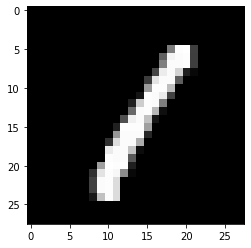

In [15]:
print(train[1][3])
_ = plt.imshow(train[0][3])

1


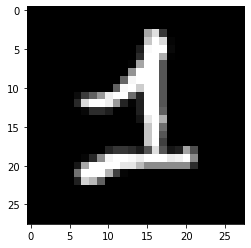

In [16]:
print(train[1][24])
_ = plt.imshow(train[0][24])

7


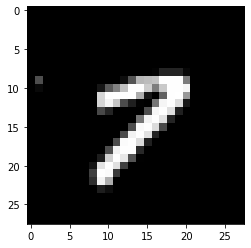

In [17]:
print(train[1][29])
_ = plt.imshow(train[0][29])

Wie man hier sehen kann ist es schwierig zu sagen ob das dritte Bild eine eins oder eine sieben ist. Da sich der
Algorithmus an der Distanz zwischen den Bildern orientiert (einfach gesagt die Anzahl der Pixel zwischen zwei
Bildern die unterschiedlich sind) kann es passieren, dass zwei Bilder die zwar verschiedene Zahlen sind, sehr ähnlich
sind (Bild 1 und 3). Und andere Bilder, die zwar die selbe Zahl sind, sind sehr verschieden (Bild 1 und 2).

Das liegt daran, dass die Art und Weise wie Zahlen geschrieben werden stark variiert. Die Algorithmen KNN und K-Means
orientieren sich nicht an Muster oder der Art und Weise wie die Zahlen geschrieben werden sondern nur an den Bildern
beziehungsweise nur an den einzelnen Pixelwerten (keine zusammenhängenden Flächen) und sind dadurch sehr
eingeschränkt in ihrer Möglichkeit die Bilder richtig zuzuordnen.

Würde man berücksichtigen wie die Zahlen geschrieben wurden, indem man die Vektoren (Striche) mit denen die Zahlen
geschrieben wurden oder zumindest die Zusammenhängendne Flächen, könnte man bessere Muster erkennen. Beispielsweise,
dass der Strich am unterem Ende der Zahl ein Anzeichen für eine eins ist und ein Strich in der Mitte der Zahl ein
Anzeichen für eine sieben.

# E KNN and K-Means CIFAR

### Laden, Splitten und Samplen der Daten

In [18]:
cifar = datasets.cifar10.load_data()

n_train = 1000
n_test = 100

train = cifar[0]
test = cifar[1]

X_train = train[0]
Y_train = train[1]

X_test = test[0]
Y_test = test[1]

In [19]:
idx = np.random.randint(X_train.shape[0], size=n_train)
X_train_sample = X_train[idx]
Y_train_sample = Y_train[idx]

In [20]:
idx = np.random.randint(X_test.shape[0], size=n_test)
X_test_sample = X_test[idx]
Y_test_sample = Y_test[idx]

### Bilder in Graustufen konvertieren 

In [21]:
X_train_sample = ski.color.rgb2gray(X_train_sample)
X_test_sample = ski.color.rgb2gray(X_test_sample)

### Samples nehmen

In [22]:
X_train_sample = X_train_sample.reshape((X_train_sample.shape[0], X_train_sample.shape[1]**2))
X_test_sample = X_test_sample.reshape((X_test_sample.shape[0], X_test_sample.shape[1]**2))

remove last dimension from Y (where ever that comes from)

In [23]:
Y_train_sample = Y_train_sample[:,0]
Y_test_sample = Y_test_sample[:,0]

### KNN mit CIFAR10 für k = 2, 4, 8

In [24]:
for k in [2, 4, 8]:
    print("\n\nk = {}".format(k))
    do_knn(X_train_sample, Y_train_sample, X_test_sample, Y_test_sample, k)



k = 2
Fehlerrate: 79%
Fehlerrate nach Label (Fehler/Total):
0: 5/8 -> 62%
1: 16/19 -> 84%
2: 6/7 -> 85%
3: 4/5 -> 80%
4: 10/11 -> 90%
5: 12/12 -> 100%
6: 8/10 -> 80%
7: 9/10 -> 90%
8: 2/11 -> 18%
9: 7/7 -> 100%


k = 4
Fehlerrate: 79%
Fehlerrate nach Label (Fehler/Total):
0: 5/6 -> 83%
1: 16/19 -> 84%
2: 5/6 -> 83%
3: 4/6 -> 66%
4: 11/12 -> 91%
5: 12/13 -> 92%
6: 7/10 -> 70%
7: 9/10 -> 90%
8: 2/10 -> 20%
9: 8/8 -> 100%


k = 8
Fehlerrate: 75%
Fehlerrate nach Label (Fehler/Total):
0: 4/6 -> 66%
1: 16/19 -> 84%
2: 5/9 -> 55%
3: 5/7 -> 71%
4: 8/8 -> 100%
5: 10/12 -> 83%
6: 7/9 -> 77%
7: 9/10 -> 90%
8: 2/11 -> 18%
9: 9/9 -> 100%


### KMeans mit CIFAR10 für k = 10 and n = 10, 100, 1000

In [25]:
for n in [10, 100, 1000]:
    print("\n\nn = {}".format(n))
    do_kmeans(n, 10, X_train_sample, Y_train_sample)



n = 10
cluster: 0 majority: 9 percentage 24
cluster: 1 majority: 8 percentage 34
cluster: 2 majority: 5 percentage 18
cluster: 3 majority: 6 percentage 19
cluster: 4 majority: 2 percentage 15
cluster: 5 majority: 2 percentage 16
cluster: 6 majority: 1 percentage 100
cluster: 7 majority: 7 percentage 24
cluster: 8 majority: 0 percentage 26
cluster: 9 majority: 2 percentage 19

3 did not get it's own cluster
4 did not get it's own cluster


n = 100
cluster: 0 majority: 8 percentage 36
cluster: 1 majority: 6 percentage 16
cluster: 2 majority: 2 percentage 19
cluster: 3 majority: 0 percentage 26
cluster: 4 majority: 6 percentage 18
cluster: 5 majority: 2 percentage 17
cluster: 6 majority: 9 percentage 25
cluster: 7 majority: 8 percentage 17
cluster: 8 majority: 7 percentage 33
cluster: 9 majority: 3 percentage 17

1 did not get it's own cluster
4 did not get it's own cluster
5 did not get it's own cluster


n = 1000
cluster: 0 majority: 9 percentage 20
cluster: 1 majority: 3 percentage 1

Wie man an den Ergebnissen sehen kann funktionieren KNN und KMeans praktisch garnicht. Die Fehlerraten bei KNN sind um
die 80% (90% wäre der Erwartungswert wenn man rät) und bei K-Means liegen die Anteile der häufisten Zahlen teilweise
nur knapp über 10% (10% wäre der Erwartungswert bei einer Zufallsverteilung).  
Das liegt vermutlich daran, dass durch das Zusammenfassen der Farbwerte in Graustufen viele Informationen verloren
gehen, denn einem Grauwert kann man immer mehrere verschiedene Farbwerte zuordnen und der Algorithmus basiert auf den
Abständen zwischen den Werten.

# F Linear Regression Boston

In [26]:
boston = datasets.boston_housing.load_data()

train = boston[0]
test = boston[1]

X_train = train[0]
Y_train = train[1]

X_test = test[0]
Y_test = test[1]

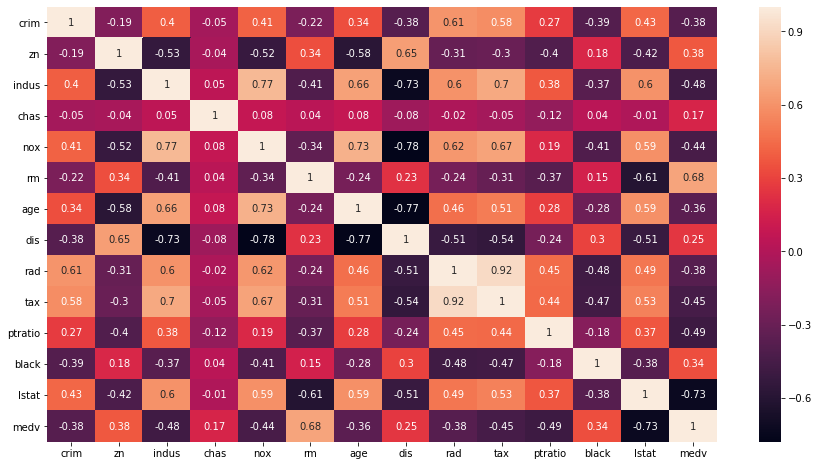

In [27]:
c = ["crim", "zn", "indus", "chas", "nox", "rm", "age", "dis", "rad", "tax", "ptratio", "black", "lstat", 'medv']
boston = pd.DataFrame({c: X_train[:, i] for i, c in enumerate(c[:-1])})
boston[c[-1]] = Y_train

plt.rcParams['figure.figsize'] = [15, 8]

correlation_matrix = boston.corr().round(2)
_ = sns.heatmap(data=correlation_matrix, annot=True)

Diese Heatmap zeit uns sehr deutlich, dass die Faktoren, die den Preis am stärksten beeinflussen, die Anzahl an Räumen
und der Prozentsatz der Menschen die einen niedriegeren Satus haben.  
Man kann auch klar erkennen, dass 'chas' ein dummy-Wert ist, der nicht mit dem eigentlichen Datensatz zu tun hat, da
er zu keinem adneren Wert eine nennenswerte Korrelation aufzeigt.  

### Trainieren des Modells

In [28]:
lin_model = LinearRegression(fit_intercept=True, normalize=False)
_ = lin_model.fit(X_train, Y_train)

### Validierung anhand der Testdaten

In [29]:
y_test_predict = lin_model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))

print('RMSE: {} * {}'.format(round(rmse, 2), "1.000$"))

RMSE: 4.82 * 1.000$


Der RMSE (Root of Mean Squared Error) ist mit 4.82 (= 4820$ durchschnittliche Abweichung) relativ gering.

# G Logistic Regression MNIST

### Daten aufteilen

In [30]:
train = mnist[0]
test = mnist[1]

X_train = train[0]
Y_train = train[1]

X_test = test[0]
Y_test = test[1]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1]**2))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1]**2))

### Samples nehmen

In [31]:
idx = np.random.randint(X_train.shape[0], size=3000)
X_train_sample = X_train[idx]
Y_train_sample = Y_train[idx]

idx = np.random.randint(X_test.shape[0], size=100)
X_test_sample = X_test[idx]
Y_test_sample = Y_test[idx]

### Modell trainieren

In [32]:
lr = LogisticRegression(multi_class='auto', solver='liblinear')
_ = lr.fit(X_train_sample, Y_train_sample)

### Testdaten berechnen lassen

In [33]:
Y_test_sample_predicted = lr.predict(X_test_sample)

### Ergebnis validieren

In [ ]:
total = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
error = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}

for idx in range(len(Y_test_sample_predicted)):
    if Y_test_sample_predicted[idx] == Y_test_sample[idx]:
        total[Y_test_sample[idx]] += 1
    else:
        total[Y_test_sample[idx]] += 1
        error[Y_test_sample[idx]] += 1

print("Fehlerrate: {}%\n".format(int(sum(error.values()) / sum(total.values()) * 100)))

print("(error/total)")
for num in total.keys():
    print("label {}: {}/{} -> {}%".format(num, error[num], total[num], int(error[num] / total[num] * 100)))

Auch hier gilt ähnlich wie bei KNN/K-Means, dass die Informationen die verwendet werden nur die einzelnen Pixel sind.
Der Algorithmus kann keine Zusammenhängenden Bereiche oder Linien erkennen die einen Hinweis auf die Form der Ziffer
geben könnten. Dementsprechend kann er die Ziffer wenn sie nur leicht rotiert oder versetzt ist nicht mehr richtig
erkennen. Die Logistic Regression hat aber den Vorteil, dass sie gewissen Pixeln eine höhere Bedeutung zuweisen kann
auch wenn das hier in dem Fall keine Hilfe ist, da die Fehlerrate höher ist. 

# H Feedback

### Wie viel Zeit habt ihr für das Assignment aufgewendet und wie oft habt ihr euch getroffen?
Max: 16  
Arne: 15  
Getroffen: 3x
### Habt ihr Google CoLab oder Anaconda verwendet?  
Nein, die Performance Anforderungen waren nicht sehr hoch.  
Jein, einmal ja (Arne) und einmal nein (Max: eine normale Python-Installation mit pip als Paketverwaltung und
PyCharm als IDE)
### Was war eure Lieblingsaufgabe? Warum?  
E, wenn man bei den ersten Aufgaben alles schön in Funktionen gefasst hatte, konnte man den Code einfach reusen.
### Was war die Aufgabe, die euch am wenigsten gefallen hat? Warum?
C, um genau die Anforderungen an die Lösung zu erfüllen haben wir keine passende Library gefunden und mussten viel von
Hand machen auch wenn man sich später als Entwickler nicht hinsetzen wird und K-Means selber programmieren würde.
### Sonstiges Feedback:  
Die Erklärung des theoretischen Hintergrunds der Algorithmen, die wir für die Aufgaben benötigt haben, war sehr gut.

Jedoch wurde der technische Teil nur unzureichend erklärt, was dazu geführt hat, dass man den gegebenen Code kopiert und
nur die Ausgabe leicht modifiziert hat.

Studenten, die keine Erfahrung mit Python haben, hatten keine Chance, sich mit dem Thema Machine Learning an sich zu
beschäftigen, da die Einführung in Python/Anaconda/Paketverwaltung zu viel Zeit in Anspruch genommen hat.

Ich (Max) hatte das Glück bereits über Vorkenntnisse in Python zu verfügen, konnte mir allerdings nicht komplett
erschließen wie die Funktionen, die wir verwendet haben, tatsächlich funktionieren.  
Für mich (Arne) lag das Hauptaugenmerk darauf ein grundlegendes Verständnis zu erlangen und Python Basics zu lernen.